In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sklearn as sk
import pandas
import numpy as np
import tensorflow as tf
import random
import os
import collections
import math
import time
import datetime
from tensorflow.contrib import learn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
from matplotlib import pylab

# Allow print picture or graph in Ipython
%matplotlib inline
# Allow print all arry if command print called
np.set_printoptions(threshold=np.inf)           

In [2]:
from load_data import load_file, separate_data_label, label_encoding

In [3]:
from text_cnn import TextCNN

In [4]:
# Load classified Document
document1 = load_file("2007ChallengeTrainData.xml")
id_doc1, labels, words1 = separate_data_label(document1)

In [5]:
# Load unclassified Document
# Load more words from these document to improve word-embedding
document2 = load_file("2007ChallengeTestDataNoCodes.xml")
id_doc2, labels2, words2 = separate_data_label(document2)            # labels2 is empty variable

In [6]:
# Joint all the data together
id_doc = id_doc1 + id_doc2
words = words1 + words2

In [7]:
# Convert multidimension array into 1D array
words = [index.split() for index in words]                           # Separate words in sentences
words = [item for sublist in words for item in sublist]              # Turn multidimension list into 1D list

In [8]:
vocabulary_size = len(words)

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  #print(count)
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

# reverse_dictionary used number index to access
# dictionary used word keyword to access
data, count, dictionary, reverse_dictionary = build_dataset(words)

del words  # Hint to reduce memory.
#add this line to modify
vocabulary_size = len(dictionary)
print('Dictionary size', len(dictionary))

Dictionary size 2000


In [9]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [10]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):  
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 5.914941
Nearest to mild: aldrich, suspicion, behind, causing, diverticulum, fulguration, done, decreased,
Nearest to neurogenic: hypoventilatory, attending, 10, 26, from, 103, signifying, r9,
Nearest to 's: nipple, wilms, retropharyngeal, albuterol, j, 1st, fellow, abnormality,
Nearest to urinary: frequent, intermittently, expanded, 180, pounds, elevation, augmented, period,
Nearest to be: bifid, valves, etiology, track, volume, resolves, minus, subsegmental,
Nearest to atelectasis: curing, causing, reactive, examinations, unknown, worrisome, feel, thought,
Nearest to x: nearly, follicle, where, calms, with, appeared, hemorrhagic, valve,
Nearest to bilateral: suprahilar, 180, very, flattened, remains, involves, grew, mri,
Nearest to 1: pattern, better, views, lining, results, remaining, cystogram, specified,
Nearest to stable: done, cuffing, normal, presumably, aspiration, anechoic, ordering, slow,
Nearest to evaluate: void, outpatient, hemidiaphrag

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


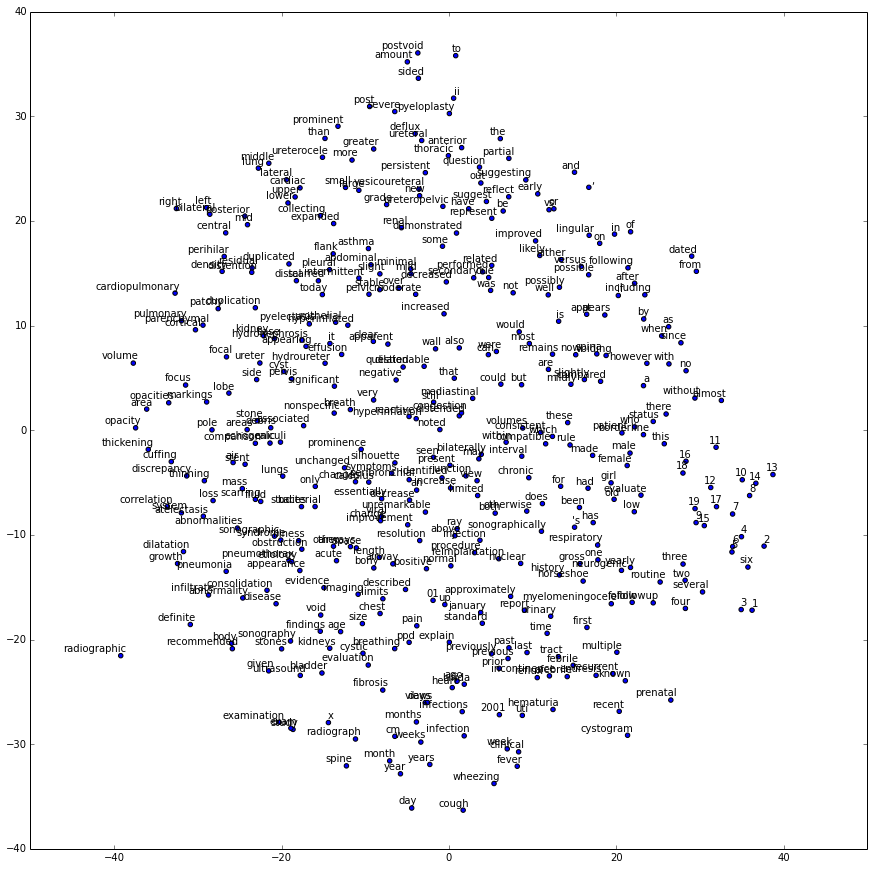

In [13]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [14]:
embedding_dim = 128
filter_sizes = [3, 4, 5]
num_filters = 128
dropout_keep_prob = 0.5
l2_reg_lambda = 0.0

In [15]:
batch_size = 64
num_epochs = 200
evaluate_every = 2
checkpoint_every = 100

In [16]:
# Create a 2D blank 2D array
# embedding size = 128
array_sentence = np.zeros((len(dictionary), embedding_size),dtype="float32")

In [17]:
# Input of Network
x = np.zeros((len(words1),len(dictionary)*embedding_size),dtype="float32")

In [18]:
# One-hot-encoding label of each document
# There are 978 documents and 45 labels
y = label_encoding(labels, False)                                      # Encode data Label in DataFrame type
y = y.as_matrix()                                               # Convert DataFrame type to numpy array                                                                       
                                                                # for other calculation

In [19]:
# Try
counter = 0
for indexDoc in words1:
    for indexWord in indexDoc:
        if indexWord in dictionary:                             # Check If the words have in dictionary
            vectLocate = dictionary[indexWord]                  # All rare words is treated as UNK Token
            array_sentence[vectLocate] = final_embeddings[vectLocate]
        else:                                                   # If the word is not in dictionary
            vectLocate = dictionary['UNK']                      # It may be a rare word
            array_sentence[vectLocate] = final_embeddings[vectLocate]
    x[counter] = array_sentence.flatten()        
    counter+=1 

del array_sentence                                              # Save memory 

In [20]:
# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

In [21]:
# Split train/test set
x_train, x_dev = x_shuffled[:-500], x_shuffled[-500:]
y_train, y_dev = y_shuffled[:-500], y_shuffled[-500:]

In [22]:
# Sort each data and label into one pair
# then shuffle to ensure randomness 
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [23]:
batches = batch_iter(
        list(zip(x_train, y_train)), batch_size, num_epochs)

In [24]:
step_store = []
accuracy_store = []
eval_step = []
eval_accuracy = []
eval_loss = []
eval_precision = []
eval_recall = []
eval_f1 = []

In [25]:
def train_step(x_batch, y_batch):
    """
    A single training step
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: dropout_keep_prob
    }
    _, step, summaries, loss, accuracy = sess.run(
        [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
        feed_dict)
    step_store.append(step)
    accuracy_store.append(accuracy)
    print("step {}, loss {:g}, acc {:g}".format(step, loss, accuracy))
    train_summary_writer.add_summary(summaries, step)

In [26]:
def dev_step(x_batch, y_batch, writer=None):
    """
    Evaluates model on a dev set
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: 1.0
    }
    step, summaries, loss, accuracy, y_p = sess.run(
        [global_step, dev_summary_op, cnn.loss, cnn.accuracy, cnn.y_p],
        feed_dict)
    eval_step.append(step)
    eval_accuracy.append(accuracy)
    eval_loss.append(loss)
    y_true = np.argmax(y_dev,1)
    precision = sk.metrics.precision_score(y_true, y_p)
    recall = sk.metrics.recall_score(y_true, y_p)
    f1_score = sk.metrics.f1_score(y_true, y_p)
    eval_precision.append(precision)
    eval_recall.append(recall)
    eval_f1.append(f1_score)
    print("step {}, loss {:g}, acc {:g}, precison {}, recall {}, f1_score {}.".format(step, loss, accuracy, precision, recall, f1_score))
    

In [ ]:
for batch in batches:
    x_batch, y_batch = zip(*batch)
    train_step(x_batch, y_batch)
    current_step = tf.train.global_step(sess, global_step)
    if current_step % evaluate_every == 0:
        print("\nEvaluation:")
        dev_step(x_dev, y_dev, writer=dev_summary_writer)
        print("")